# **Regularized Lineal Models**

array([[1.8892424 ],
       [1.09355325]])

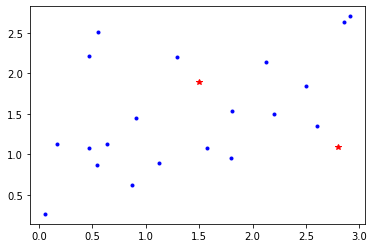

In [40]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

np.random.seed(42)
m = 20

X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

plt.plot(X,y,'b.')

x_pred = np.array([[1.5],[2.8]])
y_pred = 1 + 0.5 * x_pred + np.random.randn(2, 1) / 1.5

plt.plot(x_pred,y_pred,'r*')
y_pred

## **Regression Ridge**

In [41]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict(x_pred)


array([[1.55071465],
       [2.02235944]])

In [61]:
# And using Stochastic Gradient Descent:
from sklearn.linear_model import Ridge,LinearRegression,SGDRegressor

sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.reshape(20,))

sgd_reg.predict(x_pred)



array([1.46466445, 2.26734802])

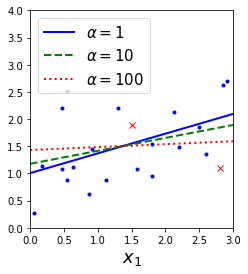

In [52]:
from sklearn.linear_model import Ridge,LinearRegression,SGDRegressor
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import Pipeline


def plot_model(model_class, polynomial, alphas, **model_kargs):

    X_new = np.linspace(0, 3, 100).reshape(100, 1)

    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.plot(x_pred, y_pred, "rx", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(1, 10,100), random_state=42)



Como podemos ver con a=100 la linea resultante es casi un linea plana paralela al eje cordenado 

## **Lasso Regression**

In [62]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
sgd_reg.predict(x_pred)


# Note that you could instead use SGDRegressor(penalty="l1").

array([1.46466445, 2.26734802])

## **Early Stopping**
Es para algoritmos iterativos y consiste en detener el aprendizaje cuando el error de validacion alcanza un minimo, justo antes de que comience a sobreajustarse a los datos de entrenamiento. 
 
Ejemplo de una implementación: 


In [65]:
from sklearn.model_selection import train_test_split
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X[:50], y[:50].ravel(), test_size=0.5, random_state=10)


In [78]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# warm_start=True, cuando se llama al método fit(), continúa el entrenamiento donde lo dejó
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")  # valor infinito
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

Create the graph:

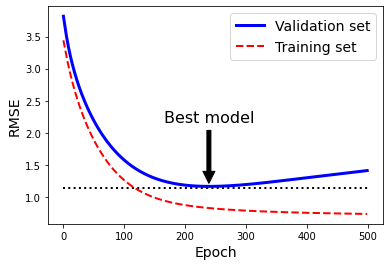

In [79]:
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
             )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()


In [76]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))